# Structure Learning in Bayesian Networks

In this notebook, we show a few examples of Causal Discovery or Structure Learning in pgmpy. pgmpy currently has the following algorithm for causal discovery:

1. **PC**: Has $3$ variants original, stable, and parallel. PC is a constraint-based algorithm that utilizes Conditional Independence tests to construct the model.
2. **Hill-Climb Search**: Hill-Climb Search is a greedy optimization-based algorithm that makes iterative local changes to the model structure such that it improves the overall score of the model.
3. **Greedy Equivalence Search (GES)**: Another score-based method that makes greedy modifications to the model to improve its score iteratively.
4. **ExpertInLoop**: An iterative algorithm that combines Conditional Independence testing with expert knowledge. The user or an LLM can act as the expert.
5. **Exhaustive Search**: Exhaustive search iterates over all possible network structures on the given variables to find the most optimal one. As it tries to enumerate all possible network structures, it is intractable when the number of variables in the data is large.

The following Conditional Independence Tests are available to use with PC algorithm.
1. **Discrete Data**: When all variables are discrete/categorical.
    1. **Chi-square test**: `ci_test="chi_square"`
    2. **G-squared**: `ci_test="g_sq"`
    3. **Log-likelihood**: Is equivalent to G-squared test. `ci_test="log_likelihood`
2. **Continuous Data**: When all variables are continuous/numerical.
    1. **Partial Correlation**: `ci_test="pearsonr"`
3. **Mixed Data**: When there is a mix of categorical and continuous variables.
    1. **Pillai**: `ci_test="pillai"`

For Hill-Climb, Exhausitive Search, and GES the following scoring methods can be used:
1. **Discrete Data**: When all variables are discrete/categorical. 
    1. **BIC Score**: `scoring_method="bic-d"`
    2. **AIC Score**: `scoring_method="aic-d"`
    3. **K2 Score**: `scoring_method="k2"`
    4. **BDeU Score**: `scoring_method="bdeu"`
    5. **BDs Score**: `scoring_method="bds"`
2. **Continuous Data**: When all variables are continuous/numerical.
    1. **Log-Likelihood**: `scoring_method="ll-g"`
    2. **AIC**: `scoring_method="aic-g"`
    3. **BIC**: `scoring_method="bic-g"`
3. **Mixed Data**: When there is a mix of discrete and continuous variables.
    1. **AIC**: `scoring_method="aic-cg"`
    2. **BIC**: `scoring_method="bic-cg"`

## 0. Simulate some sample datasets

In [1]:
from itertools import combinations

import networkx as nx
import numpy as np
from sklearn.metrics import f1_score

from pgmpy.estimators import PC, HillClimbSearch, GES
from pgmpy.utils import get_example_model
from pgmpy.metrics import SHD

c:\Users\jxq61\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Discrete variable dataset
alarm_model = get_example_model("alarm")
alarm_samples = alarm_model.simulate(int(1e3))
alarm_samples.head()

# Continuous variable dataset
ecoli_model = get_example_model("ecoli70")
ecoli_samples = ecoli_model.simulate(int(1e3))
ecoli_samples.head()

Generating for node: BP: 100%|██████████| 37/37 [00:00<00:00, 463.02it/s]


,b1191,cspG,eutG,fixC,cspA,yecO,yedE,sucA,cchB,yceP,...,dnaK,folK,ycgX,lacZ,nuoM,dnaG,b1583,mopB,yaeM,ftsJ
0,0.236195,2.288765,1.905775,0.789714,-0.770087,2.891742,-2.529511,-2.686661,0.602710,2.514428,...,-1.778680,-0.896765,-1.707150,-0.121400,-1.896694,-0.798081,1.854076,-1.826730,2.907879,-0.871770
1,0.597559,1.717203,2.225777,2.030102,-0.224709,1.267222,-0.945631,-2.241290,1.511655,1.435793,...,0.628984,1.319956,0.051735,-1.379600,-1.885674,-0.205963,1.350436,1.381979,2.378217,1.940105
2,0.107336,3.282894,2.911951,0.640488,2.746937,2.670128,-1.908708,-3.672664,2.501395,3.494058,...,-4.388125,-2.653371,-4.694778,2.280046,0.171380,-3.482192,2.592541,-3.607053,4.305313,-2.743530
3,2.235661,1.847715,1.155679,3.053696,0.524370,1.801155,-2.486285,-1.888167,3.318210,0.646790,...,-1.456752,-0.185038,-0.892459,0.943415,-0.940696,-0.763824,1.684960,-1.228802,2.712333,-0.792233
4,2.052552,2.225124,1.405402,3.501185,-0.303648,2.324970,-2.131498,-2.805020,3.001945,0.853664,...,3.319358,3.650548,2.462981,3.651905,-0.147705,2.492869,3.388589,2.710324,3.450587,2.861755


In [3]:
alarm_samples.head()

,KINKEDTUBE,FIO2,STROKEVOLUME,HRSAT,HRBP,CVP,ERRCAUTER,VENTTUBE,EXPCO2,HREKG,...,BP,PCWP,MINVOL,VENTLUNG,MINVOLSET,INSUFFANESTH,ANAPHYLAXIS,VENTMACH,TPR,DISCONNECT
0,FALSE,NORMAL,NORMAL,HIGH,HIGH,NORMAL,FALSE,LOW,LOW,HIGH,...,LOW,NORMAL,ZERO,ZERO,NORMAL,FALSE,FALSE,NORMAL,LOW,FALSE
1,FALSE,NORMAL,NORMAL,HIGH,HIGH,NORMAL,FALSE,LOW,LOW,HIGH,...,LOW,NORMAL,ZERO,ZERO,NORMAL,FALSE,FALSE,NORMAL,NORMAL,FALSE
2,FALSE,NORMAL,LOW,LOW,LOW,NORMAL,FALSE,LOW,LOW,LOW,...,LOW,NORMAL,ZERO,ZERO,NORMAL,FALSE,FALSE,NORMAL,NORMAL,FALSE
3,FALSE,NORMAL,NORMAL,LOW,LOW,LOW,FALSE,ZERO,LOW,LOW,...,NORMAL,NORMAL,HIGH,LOW,NORMAL,FALSE,FALSE,NORMAL,HIGH,TRUE
4,FALSE,NORMAL,NORMAL,HIGH,HIGH,NORMAL,FALSE,LOW,LOW,HIGH,...,HIGH,NORMAL,ZERO,ZERO,NORMAL,FALSE,FALSE,NORMAL,NORMAL,FALSE


In [4]:
# Function to evaluate the learned model structures.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_array(
        estimated_model.to_undirected(), nodelist=nodes, weight=None
    )
    true_adj = nx.to_numpy_array(
        true_model.to_undirected(), nodelist=nodes, weight=None
    )

    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)

## 1. PC algorithm

In [5]:
# Learning the discrete variable alarm model back

est = PC(data=alarm_samples)
estimated_model = est.estimate(ci_test='chi_square', variant="stable", max_cond_vars=4, return_type='dag')
get_f1_score(estimated_model, alarm_model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'KINKEDTUBE': 'C', 'FIO2': 'C', 'STROKEVOLUME': 'C', 'HRSAT': 'C', 'HRBP': 'C', 'CVP': 'C', 'ERRCAUTER': 'C', 'VENTTUBE': 'C', 'EXPCO2': 'C', 'HREKG': 'C', 'LVFAILURE': 'C', 'PAP': 'C', 'CO': 'C', 'ERRLOWOUTPUT': 'C', 'CATECHOL': 'C', 'PULMEMBOLUS': 'C', 'INTUBATION': 'C', 'SAO2': 'C', 'LVEDVOLUME': 'C', 'SHUNT': 'C', 'VENTALV': 'C', 'HYPOVOLEMIA': 'C', 'PRESS': 'C', 'ARTCO2': 'C', 'HISTORY': 'C', 'PVSAT': 'C', 'HR': 'C', 'BP': 'C', 'PCWP': 'C', 'MINVOL': 'C', 'VENTLUNG': 'C', 'MINVOLSET': 'C', 'INSUFFANESTH': 'C', 'ANAPHYLAXIS': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'DISCONNECT': 'C'}
Working for n conditional variables: 5: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]

F1-score for the model skeleton:  0.8051948051948052


In [11]:

import matplotlib.pyplot as plt


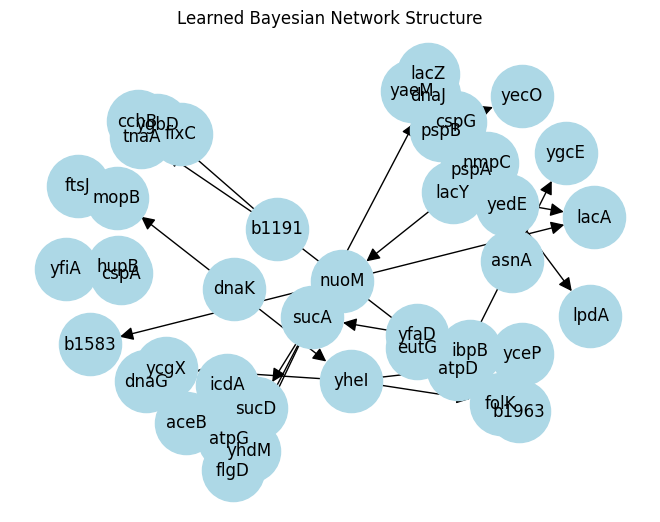

In [12]:
# 获取边列表
edges = list(estimated_model.edges())

# 创建有向图
G = nx.DiGraph()
G.add_edges_from(edges)

# 计算节点布局
pos = nx.spring_layout(G)

# 绘制图形
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', arrowsize=20)
plt.title("Learned Bayesian Network Structure")
plt.show()


In [6]:
# Learning the continuous variable ecoli model back

est = PC(data=ecoli_samples)
estimated_model = est.estimate(ci_test='pearsonr', variant="orig", max_cond_vars=4, return_type='dag')
get_f1_score(estimated_model, ecoli_model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'b1191': 'N', 'cspG': 'N', 'eutG': 'N', 'fixC': 'N', 'cspA': 'N', 'yecO': 'N', 'yedE': 'N', 'sucA': 'N', 'cchB': 'N', 'yceP': 'N', 'ygbD': 'N', 'yjbO': 'N', 'yfiA': 'N', 'lpdA': 'N', 'pspB': 'N', 'atpG': 'N', 'dnaJ': 'N', 'flgD': 'N', 'gltA': 'N', 'sucD': 'N', 'tnaA': 'N', 'ygcE': 'N', 'yhdM': 'N', 'ibpB': 'N', 'yfaD': 'N', 'hupB': 'N', 'pspA': 'N', 'asnA': 'N', 'atpD': 'N', 'nmpC': 'N', 'icdA': 'N', 'lacA': 'N', 'yheI': 'N', 'aceB': 'N', 'lacY': 'N', 'b1963': 'N', 'dnaK': 'N', 'folK': 'N', 'ycgX': 'N', 'lacZ': 'N', 'nuoM': 'N', 'dnaG': 'N', 'b1583': 'N', 'mopB': 'N', 'yaeM': 'N', 'ftsJ': 'N'}
Working for n conditional variables: 5: 100%|██████████| 5/5 [00:27<00:00,  5.50s/it]

F1-score for the model skeleton:  0.628099173553719


## 2. Hill-Climb Search Algorithm

In [6]:
# Learning the discrete variable alarm model back

est = HillClimbSearch(data=alarm_samples)
estimated_model = est.estimate(scoring_method="k2", max_indegree=4, max_iter=int(1e4))
get_f1_score(estimated_model, alarm_model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'INTUBATION': 'C', 'ANAPHYLAXIS': 'C', 'VENTLUNG': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'MINVOL': 'C', 'VENTTUBE': 'C', 'HRBP': 'C', 'BP': 'C', 'PAP': 'C', 'PULMEMBOLUS': 'C', 'DISCONNECT': 'C', 'ERRLOWOUTPUT': 'C', 'HYPOVOLEMIA': 'C', 'CVP': 'C', 'HREKG': 'C', 'CO': 'C', 'PRESS': 'C', 'HRSAT': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'PVSAT': 'C', 'ARTCO2': 'C', 'LVFAILURE': 'C', 'KINKEDTUBE': 'C', 'VENTALV': 'C', 'FIO2': 'C', 'SHUNT': 'C', 'PCWP': 'C', 'SAO2': 'C', 'HR': 'C', 'MINVOLSET': 'C', 'STROKEVOLUME': 'C', 'INSUFFANESTH': 'C', 'ERRCAUTER': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'INTUBATION': 'C', 'ANAPHYLAXIS': 'C', 'VENTLUNG': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'MINVOL': 'C', 'VENTTUBE': 'C', 'HRBP': 'C', 'BP': 'C', 'PAP': 'C', 'PULMEMBOLU

  0%|          | 0/10000 [00:00<?, ?it/s]

F1-score for the model skeleton:  0.7719298245614035


In [7]:
# Learning the continuous variable ecoli model back

est = HillClimbSearch(data=ecoli_samples)
estimated_model = est.estimate(scoring_method="bic-g", max_indegree=4, max_iter=int(1e4))
get_f1_score(estimated_model, ecoli_model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'b1191': 'N', 'cspG': 'N', 'eutG': 'N', 'fixC': 'N', 'cspA': 'N', 'yecO': 'N', 'yedE': 'N', 'sucA': 'N', 'cchB': 'N', 'yceP': 'N', 'ygbD': 'N', 'yjbO': 'N', 'yfiA': 'N', 'lpdA': 'N', 'pspB': 'N', 'atpG': 'N', 'dnaJ': 'N', 'flgD': 'N', 'gltA': 'N', 'sucD': 'N', 'tnaA': 'N', 'ygcE': 'N', 'yhdM': 'N', 'ibpB': 'N', 'yfaD': 'N', 'hupB': 'N', 'pspA': 'N', 'asnA': 'N', 'atpD': 'N', 'nmpC': 'N', 'icdA': 'N', 'lacA': 'N', 'yheI': 'N', 'aceB': 'N', 'lacY': 'N', 'b1963': 'N', 'dnaK': 'N', 'folK': 'N', 'ycgX': 'N', 'lacZ': 'N', 'nuoM': 'N', 'dnaG': 'N', 'b1583': 'N', 'mopB': 'N', 'yaeM': 'N', 'ftsJ': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'b1191': 'N', 'cspG': 'N', 'eutG': 'N', 'fixC': 'N', 'cspA': 'N', 'yecO': 'N', 'yedE': 'N', 'sucA': 'N', 'cchB': 'N', 'yceP': 'N', 'ygbD': 'N', 'yjbO': 'N', 'yfiA': 'N', 'lpdA': 'N', 'psp

  0%|          | 0/10000 [00:00<?, ?it/s]

F1-score for the model skeleton:  0.7692307692307693


### 3. GES algorithm

In [9]:
# Learning the discrete variable alarm model back

est = GES(data=alarm_samples)
estimated_model = est.estimate(scoring_method="bic-d")
get_f1_score(estimated_model, alarm_model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'INTUBATION': 'C', 'ANAPHYLAXIS': 'C', 'VENTLUNG': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'MINVOL': 'C', 'VENTTUBE': 'C', 'HRBP': 'C', 'BP': 'C', 'PAP': 'C', 'PULMEMBOLUS': 'C', 'DISCONNECT': 'C', 'ERRLOWOUTPUT': 'C', 'HYPOVOLEMIA': 'C', 'CVP': 'C', 'HREKG': 'C', 'CO': 'C', 'PRESS': 'C', 'HRSAT': 'C', 'CATECHOL': 'C', 'EXPCO2': 'C', 'PVSAT': 'C', 'ARTCO2': 'C', 'LVFAILURE': 'C', 'KINKEDTUBE': 'C', 'VENTALV': 'C', 'FIO2': 'C', 'SHUNT': 'C', 'PCWP': 'C', 'SAO2': 'C', 'HR': 'C', 'MINVOLSET': 'C', 'STROKEVOLUME': 'C', 'INSUFFANESTH': 'C', 'ERRCAUTER': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'INTUBATION': 'C', 'ANAPHYLAXIS': 'C', 'VENTLUNG': 'C', 'HISTORY': 'C', 'LVEDVOLUME': 'C', 'VENTMACH': 'C', 'TPR': 'C', 'MINVOL': 'C', 'VENTTUBE': 'C', 'HRBP': 'C', 'BP': 'C', 'PAP': 'C', 'PULMEMBOLU

F1-score for the model skeleton:  0.8444444444444444


In [10]:
# Learning the continuous variable ecoli model back

est = GES(data=ecoli_samples)
estimated_model = est.estimate(scoring_method="bic-g")
get_f1_score(estimated_model, ecoli_model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'b1191': 'N', 'cspG': 'N', 'eutG': 'N', 'fixC': 'N', 'cspA': 'N', 'yecO': 'N', 'yedE': 'N', 'sucA': 'N', 'cchB': 'N', 'yceP': 'N', 'ygbD': 'N', 'yjbO': 'N', 'yfiA': 'N', 'lpdA': 'N', 'pspB': 'N', 'atpG': 'N', 'dnaJ': 'N', 'flgD': 'N', 'gltA': 'N', 'sucD': 'N', 'tnaA': 'N', 'ygcE': 'N', 'yhdM': 'N', 'ibpB': 'N', 'yfaD': 'N', 'hupB': 'N', 'pspA': 'N', 'asnA': 'N', 'atpD': 'N', 'nmpC': 'N', 'icdA': 'N', 'lacA': 'N', 'yheI': 'N', 'aceB': 'N', 'lacY': 'N', 'b1963': 'N', 'dnaK': 'N', 'folK': 'N', 'ycgX': 'N', 'lacZ': 'N', 'nuoM': 'N', 'dnaG': 'N', 'b1583': 'N', 'mopB': 'N', 'yaeM': 'N', 'ftsJ': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'b1191': 'N', 'cspG': 'N', 'eutG': 'N', 'fixC': 'N', 'cspA': 'N', 'yecO': 'N', 'yedE': 'N', 'sucA': 'N', 'cchB': 'N', 'yceP': 'N', 'ygbD': 'N', 'yjbO': 'N', 'yfiA': 'N', 'lpdA': 'N', 'psp

F1-score for the model skeleton:  0.8461538461538461


## 4. Expert In Loop Algorithm

Please refer to the following blogpost for more details: https://medium.com/gopenai/llms-for-causal-discovery-745e2cba0b59